In [92]:
import numpy as np

import matplotlib.pyplot as plt
from funcs import plot_settings
plot_settings()

plt.rcParams["figure.figsize"] = (8, 8)

In [93]:
d = np.load("data_ring.npy")

In [107]:
angle = np.linspace(0, 2*np.pi, 1000, endpoint=False)
target = np.empty((len(angle), 2))
target[:,0] = d[0]
target[:,1] = d[1]

In [108]:
# # Параметры для обучения
# r = 1.5
# center = np.array([0, 0])
# sigma = 0.5
# size = 1000
# target = np.empty((size, 2))

# angle = np.random.random((size,))*2*np.pi

# target[:, 0] =r*np.cos(angle) + np.random.normal(0, sigma, (size, )) + center[0]
# target[:, 1] =r*np.sin(angle) + np.random.normal(0, sigma, (size, )) + center[1]


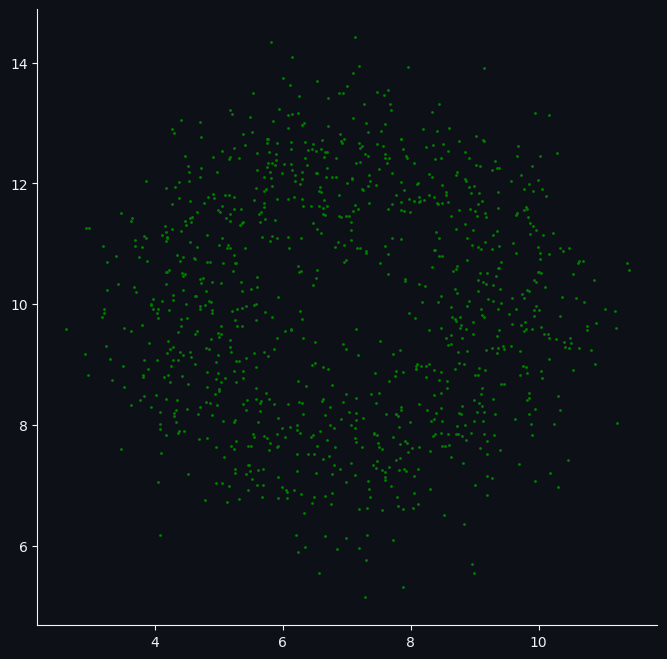

In [109]:
plt.scatter(target[:,0], target[:,1], 1)
# plt.title(f"dataset with normal noise ($\sigma=${sigma:.0e})")
plt.show()

In [110]:
def circle(phi, r, center):
    res = np.empty((len(phi), 2))
    res[:, 0] = center[0] + r*np.cos(phi)
    res[:, 1] = center[1] + r*np.sin(phi)
    return res


In [111]:
class CircleRegression():

    def __init__(self, learning_rate: float = 1e-2, max_iter: int = 100, early_stop_eps: float = 1e-2):
        """regressor for 2D circle 

        Args:
            learning_rate (float, optional): gradient step. Defaults to 1e-2.
            max_iter (int, optional): max iteration for. Defaults to 100.
            early_stop_eps (float, optional): accuracy of error step. Defaults to 1e-2.
        """

        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.iter = 0
        self.early_stop_eps = early_stop_eps
        self.loss = []
        self.cur_loss = np.inf

    def fit(self, data: np.ndarray, target: np.ndarray):
        """fit with MSE loss

        Args:
            data (np.ndarray): data samples (phi)
            target (np.ndarray): xy coordinates

        Returns:
            CircleRegression: fitted regressor
        """

        self.data = data
        self.target = target

        self.m, self.n = data.shape

        self.R = 0
        self.C = np.zeros((self.n,))

        self.xy = np.empty_like(target)
        self.xy[:, 0] = np.cos(data).flatten()
        self.xy[:, 1] = np.sin(data).flatten()

        for _ in range(self.max_iter):
            self.update_weights()
            if abs(self.cur_loss - self.loss[-1]) < self.early_stop_eps:
                break
            self.cur_loss = self.loss[-1]
        self.cur_loss = self.loss[-1]

        return self

    def update_weights(self):

        Y_pred = self.predict(self.data)

        dW = -(2 * np.sum((self.xy.T).dot(self.target - Y_pred)) / self.m)
        db = -2 * np.sum(self.target - Y_pred, axis=0) / self.m

        self.R = self.R - self.learning_rate * dW
        self.C = self.C - self.learning_rate * db

        self.loss.append(np.mean((self.target - Y_pred)**2))
        self.iter += 1

        return self

    def predict(self, X):
        xy = np.empty_like(self.target)
        xy[:, 0] = np.sin(X.flatten())
        xy[:, 1] = np.cos(X.flatten())

        return self.R*self.xy + self.C

In [112]:
regressor = CircleRegression(learning_rate=1e-1,max_iter=1000, early_stop_eps=1e-4).fit(np.array([[a] for a in angle]), target)

In [113]:
predicted = regressor.predict(angle)

Text(0.5, 1.0, 'predicted R=2.4852, center: X_c = 6.9800, Y_c = 9.9722')

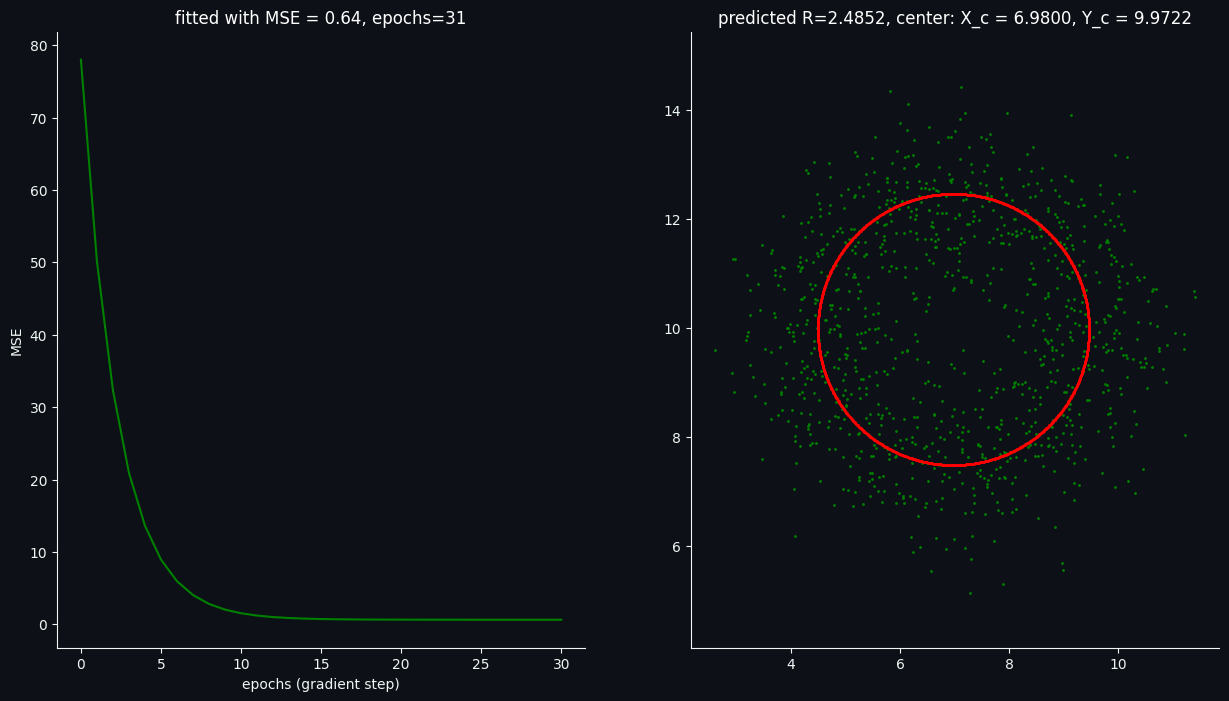

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))


axes[0].plot(regressor.loss)
axes[0].set_ylabel("MSE")
axes[0].set_xlabel("epochs (gradient step)")
axes[0].set_title(f"fitted with MSE = {regressor.cur_loss:.2f}, epochs={regressor.iter}")


axes[1].scatter(target[:,0], target[:,1], 1)

axes[1].scatter(predicted[:, 0], predicted[:,1], 1)
axes[1].axis("equal")
axes[1].set_title(f"predicted R={regressor.R:.4f}, center: X_c = {regressor.C[0]:.4f}, Y_c = {regressor.C[1]:.4f}")

In [121]:
np.linalg.norm(target[:,0] - regressor.predict(angle)[:,0])

25.328260287462413

In [122]:
np.mean((target[:,0] - regressor.predict(angle)[:,0])**2)

0.6415207691894455